In [ ]:
import numpy as np
import time
import math
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import seaborn as sns

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

### Class definition

In [ ]:
#random.seed(161)
random.seed(161)
n_points = 6000
n_labeled = int(n_points * 0.01)
n_unlabeled = n_points - n_labeled

### DEFINITION OF THE FIRST CLASS (label 1)

# Unlabeled points

random_vector1 = np.random.uniform(0, 1, int(n_unlabeled/2))
t1 = 2 * np.pi * random_vector1 
r1 = 1.2 * np.sqrt(random_vector1)
x1 = 5 - r1 * np.cos(t1) + np.random.standard_normal(int(n_unlabeled/2))/30 # x coordinate
y1 = 8.5 - r1 * np.sin(t1) + np.random.standard_normal(int(n_unlabeled/2))/30 # y coordinate

# Labeled points
random_vector1_lab = np.random.uniform(0, 1, int(n_labeled/2))
t1 = 2 * np.pi * random_vector1_lab 
r1 = 1.2 * np.sqrt(random_vector1_lab)
x1_l = 5 - r1 * np.cos(t1) + np.random.standard_normal(int(n_labeled/2))/30 # x coordinate
y1_l = 8.5 - r1 * np.sin(t1) + np.random.standard_normal(int(n_labeled/2))/30 # y coordinate

In [ ]:
### DEFINITION OF THE SECOND CLASS (label -1)

# Unlabeled points
random_vector2 = np.random.uniform(0, 1, int(n_unlabeled/2))
t2 = 2 * np.pi * random_vector2 # theta
r2 = 0.7 * np.sqrt(random_vector2) # radius
x2 = 4.5 + r2 * np.cos(t2) + np.random.standard_normal(int(n_unlabeled/2))/30; # x coordinate
y2 = 7.4 - r2* np.sin(t2) + np.random.standard_normal(int(n_unlabeled/2))/30; # y coordinate

# Labeled points
random_vector2_lab = np.random.uniform(0, 1, int(n_labeled/2))
t2 = 2 * np.pi * random_vector2_lab # theta
r2 = 0.7 * np.sqrt(random_vector2_lab) # radius
x2_l = 4.5 + r2 * np.cos(t2) + np.random.standard_normal(int(n_labeled/2))/30; # x coordinate
y2_l = 7.4 - r2 * np.sin(t2) + np.random.standard_normal(int(n_labeled/2))/30; # y coordinate

CPU times: user 57.7 ms, sys: 1.16 ms, total: 58.8 ms
Wall time: 62.3 ms


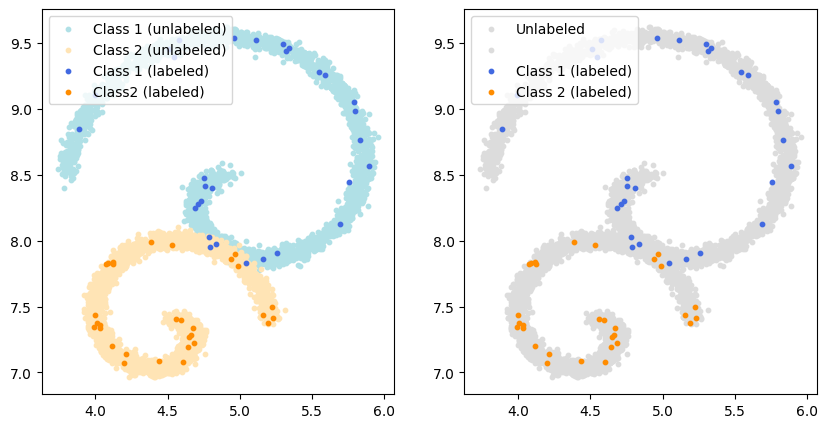

In [ ]:
%%time
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))
ax1.scatter(x1, y1, s=10, c='powderblue')
ax1.scatter(x2, y2, s=10, c='moccasin')
ax1.scatter(x1_l, y1_l, s=10, c='royalblue')
ax1.scatter(x2_l, y2_l, s=10, c='darkorange')
ax1.legend(["Class 1 (unlabeled)", "Class 2 (unlabeled)", "Class 1 (labeled)", "Class2 (labeled)"], loc = "upper left")


ax2.scatter(x1, y1, s=10, c='gainsboro')
ax2.scatter(x2, y2, s=10, c='gainsboro')
ax2.scatter(x1_l, y1_l, s=10, c='royalblue')
ax2.scatter(x2_l, y2_l, s=10, c='darkorange')
ax2.legend(["Unlabeled", "" ,"Class 1 (labeled)", "Class 2 (labeled)"], loc = "upper left")

In [ ]:
x_unlabeled = np.concatenate((x1, x2))
y_unlabeled = np.concatenate((y1, y2))
unlabeled = np.array([[x,y] for x, y in zip(x_unlabeled, y_unlabeled)])
unlabels = np.concatenate((np.ones(int(n_unlabeled/2)), -np.ones(int(n_unlabeled/2))))

x_labeled = np.concatenate((x1_l, x2_l))
y_labeled = np.concatenate((y1_l, y2_l))
labeled = np.array([[x,y] for x, y in zip(x_labeled, y_labeled)])
labels = np.concatenate((np.ones(int(n_labeled/2)), -np.ones(int(n_labeled/2))))


In [ ]:
%%time
def similarity (x, y):
  dist = np.linalg.norm(x-y, 2)
  return 1/(0.001+dist)


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


In [ ]:
%%time
w_lu = np.zeros((n_labeled, n_unlabeled))
for i in range(n_labeled):
  for j in range(n_unlabeled):
    w_lu[i,j] = similarity(labeled[i], unlabeled[j])

CPU times: user 2.66 s, sys: 185 ms, total: 2.84 s
Wall time: 2.76 s


In [ ]:
%%time
w_uu = np.zeros((n_unlabeled, n_unlabeled))
diagonal = []
for i in range(n_unlabeled):
    for j in range(i, n_unlabeled):
        w_uu[i, j] = similarity(unlabeled[i], unlabeled[j])

        if i == j:
            diagonal.append(w_uu[i, i])

w_uu = w_uu + w_uu.T - np.diag(diagonal)

CPU times: user 2min 24s, sys: 20.4 s, total: 2min 45s
Wall time: 2min 41s


In [ ]:
scaler = MinMaxScaler()
scaler.fit(w_uu)
w_uu = scaler.transform(w_uu)

scaler.fit(w_lu)
w_lu = scaler.transform(w_lu)

In [ ]:
%%time
def Hessian2():
  hessian = -2 * w_uu
  diag = [(2 * (np.sum(w_lu[:,j]) + np.sum(w_uu[:,j]))) for j in range(n_unlabeled)]
  np.fill_diagonal(hessian,diag)
  return hessian

h = Hessian2()
eigs=np.linalg.eigvalsh(h)
L = np.amax(eigs)

CPU times: user 1min 32s, sys: 3.47 s, total: 1min 35s
Wall time: 55.7 s


In [ ]:
Li = np.array([h[i][i] for i in range(len(h))])
probs = Li/ np.sum(Li)

### Formalization of the problem ### 

In [ ]:
def gradient(y):
    grad=[]
    for j in range(n_unlabeled):
        p_0, p_1, p_2, p_3 = 0, 0, 0, 0
        p_0 = np.sum(w_lu[:,j]) + np.sum(w_uu[:,j])
        p_1 = p_0*y[j]
        p_2 = np.dot(w_lu[:,j], labels)
        p_3 = np.dot(w_uu[:,j], y)
        result = 2*(p_1 - p_2 - p_3)
        grad.append(result)

    return np.array(grad) 

In [ ]:
def vector_gradient(y):
    vector_1,vector_2,vector_3,vector_4 = 0,0,0,0
    vector_1 = np.multiply(np.sum(w_lu, axis = 0), y)
    vector_2 = np.dot(np.float128(w_lu.T), np.float128(labels))
    vector_3 = np.multiply(np.sum(w_uu, axis = 0), y)
    vector_4 = np.dot(w_uu.T, y)

    return 2*(vector_1 - vector_2 + vector_3 - vector_4)

In [ ]:
def loss(y):
    start = time.time()
    term_1, term_2 = 0, 0
    for i in range(n_labeled):
      for j in range(n_unlabeled):
        term_1 += w_lu[i,j] * (y[j]-labels[i])**2
    for i in range(n_unlabeled):
      for j in range(n_unlabeled):
        term_2 += w_uu[i,j] * (y[i] - y[j])**2
    end = time.time()
    print(end - start)
    return term_1 + term_2/2

In [ ]:
def vector_loss(y):

    # term 1
    loss = 0
    loss += np.dot(np.sum(w_lu, axis = 0), y**2)
    loss += np.dot(np.sum(w_lu, axis = 1), labels**2)
    loss -= 2 * np.dot(np.dot(w_lu, y).T, labels)
    
    # term 2
    loss += 0.5 * np.dot(np.sum(w_uu, axis = 0), y**2)
    loss += 0.5 * np.dot(np.sum(w_uu, axis = 1), y**2)
    loss -= np.dot(np.dot(w_uu, y).T, y)
    
    return loss

In [ ]:
def accuracy(y_model): #y_model is the output of one of the models
    y_model_binary = [1 if i >= 0 else -1 for i in y_model]
    return np.sum(np.equal(y_model_binary,unlabels)/ len(unlabels))*100

In [ ]:
y_0 = np.random.uniform(-1, 1, n_unlabeled)

## Gradient descent

### Gradient descent with fixed step size

In [ ]:
def gradient_fixed(y_0):
  start = time.time()
  y = y_0.copy()
  numiter = 0
  tol = 1e-2
  norm_incr = 1
  normgrad = 1
  maxiter = 25000

  old_loss = vector_loss(y)

  init_time = time.time() * 1000

  ticks_gd = [time.time() * 1000 - init_time] # CPU time
  vec_accuracy_gd = [accuracy(y)] # accuracy
  vec_iter_gd = [0] # number of iterations
  vec_loss_gd = [old_loss] # loss

  print("Initial loss = {} -- Initial accuracy = {}".format(vec_loss_gd[0], vec_accuracy_gd[0]))

  while numiter < maxiter and norm_incr > tol: 

    numiter += 1

    d = -vector_gradient(y) 
    normgrad = np.linalg.norm(d, 2)
    y = y + 1/L * d.T

    loss = vector_loss(y) # loss of the precedent iteration
    acc = accuracy(y) # accuracy of the precedent iteration
    
    vec_accuracy_gd.append(acc)
    vec_iter_gd.append(numiter)
    vec_loss_gd.append(loss)

    norm_incr = abs(old_loss - loss) # absolute value between the loss in two consecutive iterations
    old_loss = loss

    print("Iterazione {} -- Loss: {} -- Accuracy: {}%".format(numiter, loss, acc))
    ticks_gd.append(time.time() * 1000 - init_time)
    

  end = time.time()
  print(y)
 
  return y, vec_iter_gd, vec_accuracy_gd, vec_loss_gd, ticks_gd

In [ ]:
%%time
### WE CALL THE FUNCTION GRADIENT DESCEND ###

y_GDfixed, vec_iter_gd, vec_accuracy_gd, vec_loss_gd, ticks_gd = gradient_fixed(y_0)
y_GDfixed

Initial loss = 55362.93626474083 -- Initial accuracy = 50.48821548821548
Iterazione 1 -- Loss: 29655.994018344667 -- Accuracy: 64.68013468013467%
Iterazione 2 -- Loss: 23781.531150186784 -- Accuracy: 82.39057239057237%
Iterazione 3 -- Loss: 21648.981614163462 -- Accuracy: 90.40404040404039%
Iterazione 4 -- Loss: 20652.880282970207 -- Accuracy: 93.36700336700335%
Iterazione 5 -- Loss: 20122.96340392408 -- Accuracy: 94.02356902356901%
Iterazione 6 -- Loss: 19819.41917815486 -- Accuracy: 94.36026936026934%
Iterazione 7 -- Loss: 19636.85525085164 -- Accuracy: 94.32659932659931%
Iterazione 8 -- Loss: 19522.9747425535 -- Accuracy: 94.34343434343432%
Iterazione 9 -- Loss: 19449.801747355697 -- Accuracy: 94.30976430976429%
Iterazione 10 -- Loss: 19401.583853326654 -- Accuracy: 94.34343434343432%
Iterazione 11 -- Loss: 19369.102673243196 -- Accuracy: 94.29292929292927%
Iterazione 12 -- Loss: 19346.79178165386 -- Accuracy: 94.29292929292927%
Iterazione 13 -- Loss: 19331.198506574863 -- Accuracy:

array([ 0.15736648,  0.69144936, -0.00677363, ..., -0.67350736,
       -0.61678734, -0.67003354], dtype=float128)

CPU times: user 93.2 ms, sys: 531 µs, total: 93.8 ms
Wall time: 107 ms


Text(0, 0.5, 'Loss')

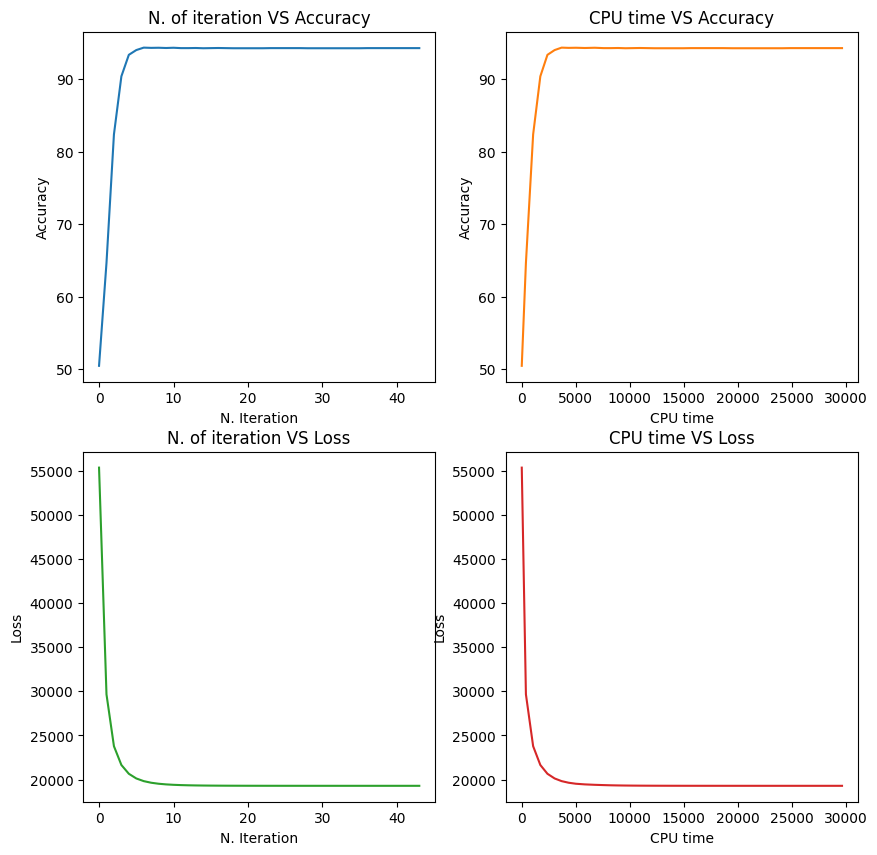

In [ ]:
%%time
### WE PLOT THE RESULTS ###
fig, axs = plt.subplots(2, 2,figsize=(10,10))
axs[0, 0].plot(vec_iter_gd,vec_accuracy_gd,'tab:blue')
axs[0, 0].set_title('N. of iteration VS Accuracy')
axs[0, 0].set_xlabel('N. Iteration')
axs[0, 0].set_ylabel("Accuracy")

axs[0, 1].plot(ticks_gd , vec_accuracy_gd, 'tab:orange')
axs[0, 1].set_title('CPU time VS Accuracy')
axs[0, 1].set_xlabel('CPU time')
axs[0, 1].set_ylabel("Accuracy")

axs[1, 0].plot(vec_iter_gd, vec_loss_gd, 'tab:green')
axs[1, 0].set_title('N. of iteration VS Loss')
axs[1, 0].set_xlabel('N. Iteration')
axs[1, 0].set_ylabel('Loss')

axs[1, 1].plot(ticks_gd , vec_loss_gd, 'tab:red')
axs[1, 1].set_title('CPU time VS Loss')
axs[1, 1].set_xlabel('CPU time')
axs[1, 1].set_ylabel('Loss')






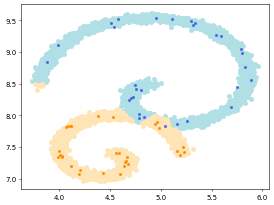

In [ ]:

y_GDfixed = [1 if i >= 0 else -1 for i in y_GDfixed]

x1_GD = x_unlabeled[y_GDfixed==np.ones(n_unlabeled)]
y1_GD = y_unlabeled[y_GDfixed==np.ones(n_unlabeled)]
x2_GD = x_unlabeled[y_GDfixed==-np.ones(n_unlabeled)]
y2_GD = y_unlabeled[y_GDfixed==-np.ones(n_unlabeled)]
plt.figure(dpi=50)
plt.scatter(x1_GD,y1_GD,c='powderblue')
plt.scatter(x2_GD,y2_GD,c='moccasin')
plt.scatter(x1_l, y1_l, s=10, c='royalblue')
plt.scatter(x2_l, y2_l, s=10, c='darkorange')

### Gradient descent with Armijo rule

In [ ]:
%%time
def Armijo(x, d):
  
  delta = 0.5 #1/2 # tra (0,1)
  gamma = 1e-4 #1e-4 tra (0, 1/2)
  alpha = 1
  step_size = 1
  m = 0

  while vector_loss(x + alpha*d) > (vector_loss(x) + gamma * alpha * np.dot(gradient(x).T, d)):
    alpha = delta**m * step_size
    m += 1

  return alpha

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs


In [ ]:
def GS_Armijo(y_0):
  start = time.time()
  y = y_0.copy()
  numiter = 0
  tol = 1e-3
  normgrad = 1
  norm_incr = 1
  maxiter = 25000

  old_loss = vector_loss(y)

  init_time = time.time() * 1000

  vec_iter_gsArmijo=[0]
  vec_accuracy_gsArmijo=[accuracy(y)]
  vec_loss_gsArmijo=[old_loss]
  ticks_gsArmijo=[time.time() * 1000 - init_time]

  print("Initial loss = {} -- Initial accuracy = {}".format(vec_loss_gd[0], vec_accuracy_gd[0]))


  while numiter < maxiter and norm_incr > tol: 

    numiter += 1

    d = -gradient(y)
    normgrad = np.linalg.norm(d, 2)
    alpha = Armijo(y, d)
    y = y + alpha * d.T

    loss = vector_loss(y)
    acc = accuracy(y)

    vec_iter_gsArmijo.append(numiter)
    vec_accuracy_gsArmijo.append(acc)
    vec_loss_gsArmijo.append(loss)

    norm_incr = abs(old_loss - loss)
    old_loss = loss
   
    if numiter == 0:
        print("Iterazione {} with alpha = {} -- Loss = {} -- Accuracy = {}%".format(numiter, 0, loss, acc))
    else:
        print("Iterazione {} with alpha = {} -- Loss = {} -- Accuracy = {}%".format(numiter, alpha, loss, acc))
    
    ticks_gsArmijo.append(time.time() * 1000 - init_time)
  end = time.time()
  print("Time = {}".format((end-start)))

  print(y)
  return y, vec_iter_gsArmijo, vec_accuracy_gsArmijo, vec_loss_gsArmijo, ticks_gsArmijo

In [ ]:
%%time
### WE CALL THE FUNCTION GRADIENT DESCEND WITH ARMIJO ###
y_GS_Armijo, vec_iter_gsArmijo, vec_accuracy_gsArmijo, vec_loss_gsArmijo, ticks_gsArmijo = GS_Armijo(y_0)

Initial loss = 55362.93626474083 -- Initial accuracy = 50.48821548821548
Iterazione 1 with alpha = 0.0625 -- Loss = 42654.466433928785 -- Accuracy = 80.33670033670033%
Iterazione 2 with alpha = 0.03125 -- Loss = 20410.505862871352 -- Accuracy = 93.60269360269359%
Iterazione 3 with alpha = 0.03125 -- Loss = 19596.591715704617 -- Accuracy = 94.39393939393939%
Iterazione 4 with alpha = 0.0625 -- Loss = 19479.135411101302 -- Accuracy = 94.2255892255892%
Iterazione 5 with alpha = 0.03125 -- Loss = 19344.193565414243 -- Accuracy = 94.24242424242422%
Iterazione 6 with alpha = 0.03125 -- Loss = 19315.558226152556 -- Accuracy = 94.27609427609427%
Iterazione 7 with alpha = 0.0625 -- Loss = 19304.735897555074 -- Accuracy = 94.27609427609426%
Iterazione 8 with alpha = 0.03125 -- Loss = 19295.249283890913 -- Accuracy = 94.29292929292927%
Iterazione 9 with alpha = 0.0625 -- Loss = 19295.047572488602 -- Accuracy = 94.27609427609426%
Iterazione 10 with alpha = 0.03125 -- Loss = 19290.626636180437 -- A

CPU times: user 96.8 ms, sys: 76.5 ms, total: 173 ms
Wall time: 90.3 ms


Text(0, 0.5, 'Loss')

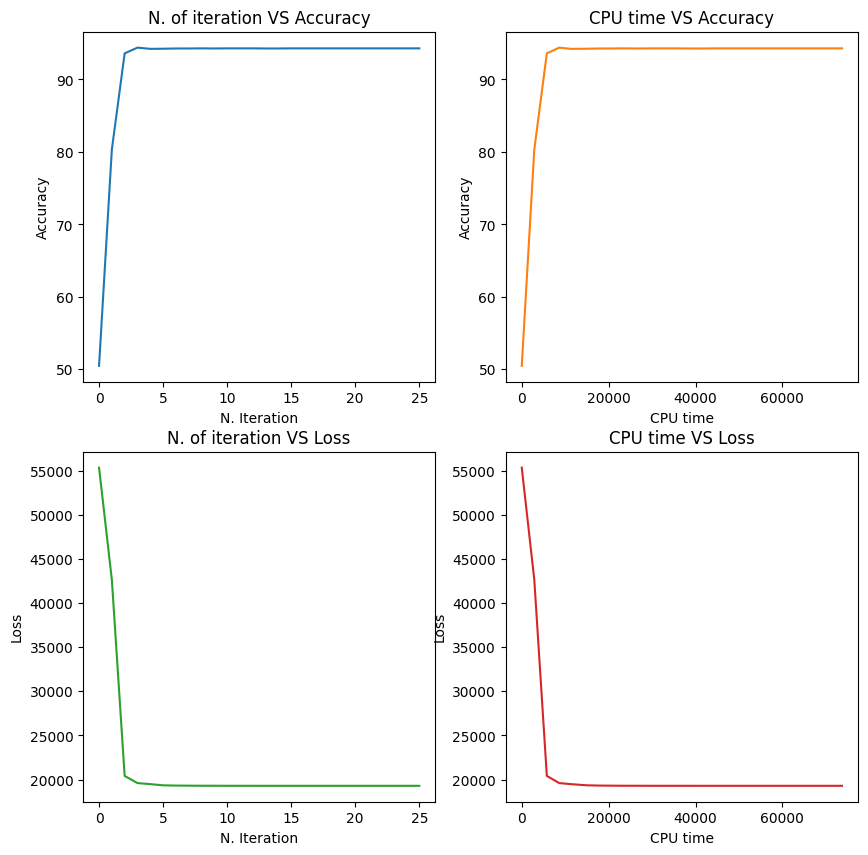

In [ ]:
%%time
### WE PLOT THE RESULTS ###
fig, axs = plt.subplots(2, 2,figsize=(10,10))
axs[0, 0].plot(vec_iter_gsArmijo, vec_accuracy_gsArmijo, 'tab:blue')
axs[0, 0].set_title('N. of iteration VS Accuracy')
axs[0, 0].set_xlabel('N. Iteration')
axs[0, 0].set_ylabel("Accuracy")

axs[0, 1].plot(ticks_gsArmijo, vec_accuracy_gsArmijo, 'tab:orange')
axs[0, 1].set_title('CPU time VS Accuracy')
axs[0, 1].set_xlabel('CPU time')
axs[0, 1].set_ylabel("Accuracy")

axs[1, 0].plot(vec_iter_gsArmijo, vec_loss_gsArmijo, 'tab:green')
axs[1, 0].set_title('N. of iteration VS Loss')
axs[1, 0].set_xlabel('N. Iteration')
axs[1, 0].set_ylabel('Loss')

axs[1, 1].plot(ticks_gsArmijo , vec_loss_gsArmijo, 'tab:red')
axs[1, 1].set_title('CPU time VS Loss')
axs[1, 1].set_xlabel('CPU time')
axs[1, 1].set_ylabel('Loss')

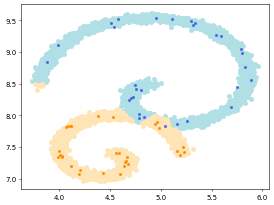

In [ ]:
y_GS_Armijo = [1 if i >= 0 else -1 for i in y_GS_Armijo]

x1_GS = x_unlabeled[y_GS_Armijo==np.ones(n_unlabeled)]
y1_GS = y_unlabeled[y_GS_Armijo==np.ones(n_unlabeled)]
x2_GS = x_unlabeled[y_GS_Armijo==-np.ones(n_unlabeled)]
y2_GS = y_unlabeled[y_GS_Armijo==-np.ones(n_unlabeled)]
plt.figure(dpi=50)
plt.scatter(x1_GS,y1_GS,c='powderblue')
plt.scatter(x2_GS,y2_GS,c='moccasin')
plt.scatter(x1_l, y1_l, s=10, c='royalblue')
plt.scatter(x2_l, y2_l, s=10, c='darkorange')

### Gradient descent with exact line search

In [ ]:
%%time
def exact_line_search(y, d):
       
    num_lu = 0  # double sommatory labeled/unlabeled at the nominator
    num_uu = 0  # double sommatory unlabeled/unlabeled at the nominator
    den_lu = 0  # double sommatory labeled/unlabeled at the denominator
    den_uu = 0  # double sommatory unlabeled/unlabeled at the denominator
            
    num_lu = np.sum(np.dot(w_lu, np.multiply(d, y))) - np.sum((np.dot(np.dot(w_lu, d), labels)))
    den_lu = np.sum(np.dot(w_lu, d.T**2))
    num_uu = np.sum(np.dot(w_uu, np.multiply(y, d))) - np.sum(np.dot(np.dot(w_uu, y), d))
    den_uu = np.sum(np.dot(w_uu, d**2)) - np.sum(np.dot(np.dot(w_uu, d), d))
    alpha = - (num_lu + num_uu)/(den_uu + den_lu)

    # the factor 2 goes away
    
    return alpha

def gradient_descent_ELS(y_0):
    
    start = time.time()
    y = y_0.copy()  # starting point
    tol = 1e-3
    normgrad = 1
    norm_incr = 1
    numiter = 0 #numero di iterazioni
  
    maxiter = 25000 # maximum number of iterations
    old_loss = vector_loss(y)

    init_time = time.time() * 1000

    vec_accuracy_ELS = [accuracy(y)]
    vec_iter_ELS = [0]
    vec_loss_ELS = [old_loss]
    ticks_ELS = [time.time() * 1000 - init_time]

    print("Initial loss = {} -- Initial accuracy = {}".format(vec_loss_gd[0], vec_accuracy_gd[0]))

    while numiter < maxiter and norm_incr > tol:

        numiter += 1

        d = - vector_gradient(y)
        normgrad = np.linalg.norm(d, 2)
        alpha = exact_line_search(y, d)
        y = y + alpha * d.T

        loss = vector_loss(y)
        acc = accuracy(y)

        norm_incr = abs(loss - old_loss)
        old_loss = loss

        vec_accuracy_ELS.append(acc)
        vec_iter_ELS.append(numiter)
        vec_loss_ELS.append(loss)

        if numiter == 0:
            print("Iterazione {} with alpha = {} -- Loss = {} -- Accuracy = {}%".format(numiter, 0, loss, acc))
        else:
            print("Iterazione {} with alpha = {} -- Loss = {} -- Accuracy = {}%".format(numiter, alpha, loss, acc))
    

        ticks_ELS.append(time.time() * 1000 - init_time)
    end = time.time()
    print(y)
    print("Time = {}".format((end-start)))
    return y,vec_iter_ELS ,vec_accuracy_ELS ,vec_loss_ELS ,ticks_ELS



CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 9.54 µs


In [ ]:
%%time
### WE CALLTHE FUNCTION GRADIENT DESCEND WITH EXACT LINE SEARCH ###
y_GS_ELS, vec_iter_ELS, vec_accuracy_ELS, vec_loss_ELS, ticks_ELS = gradient_descent_ELS(y_0)


Initial loss = 55362.93626474083 -- Initial accuracy = 50.48821548821548
Iterazione 1 with alpha = 0.035262707600080025 -- Loss = 24035.91865255487 -- Accuracy = 84.68013468013467%
Iterazione 2 with alpha = 0.042309430777042585 -- Loss = 20655.72185779054 -- Accuracy = 93.83838383838383%
Iterazione 3 with alpha = 0.035792886858965214 -- Loss = 19799.916563642244 -- Accuracy = 94.34343434343432%
Iterazione 4 with alpha = 0.041057348542207266 -- Loss = 19507.43557918496 -- Accuracy = 94.4107744107744%
Iterazione 5 with alpha = 0.035102496690854655 -- Loss = 19393.796072431935 -- Accuracy = 94.3097643097643%
Iterazione 6 with alpha = 0.040279706652740006 -- Loss = 19341.341637338595 -- Accuracy = 94.25925925925924%
Iterazione 7 with alpha = 0.03464435369530819 -- Loss = 19317.489604456707 -- Accuracy = 94.29292929292927%
Iterazione 8 with alpha = 0.0394543095279955 -- Loss = 19304.407159780294 -- Accuracy = 94.27609427609427%
Iterazione 9 with alpha = 0.03393342006194074 -- Loss = 19298.0

CPU times: user 73.4 ms, sys: 2.58 ms, total: 76 ms
Wall time: 77 ms


Text(0, 0.5, 'Loss')

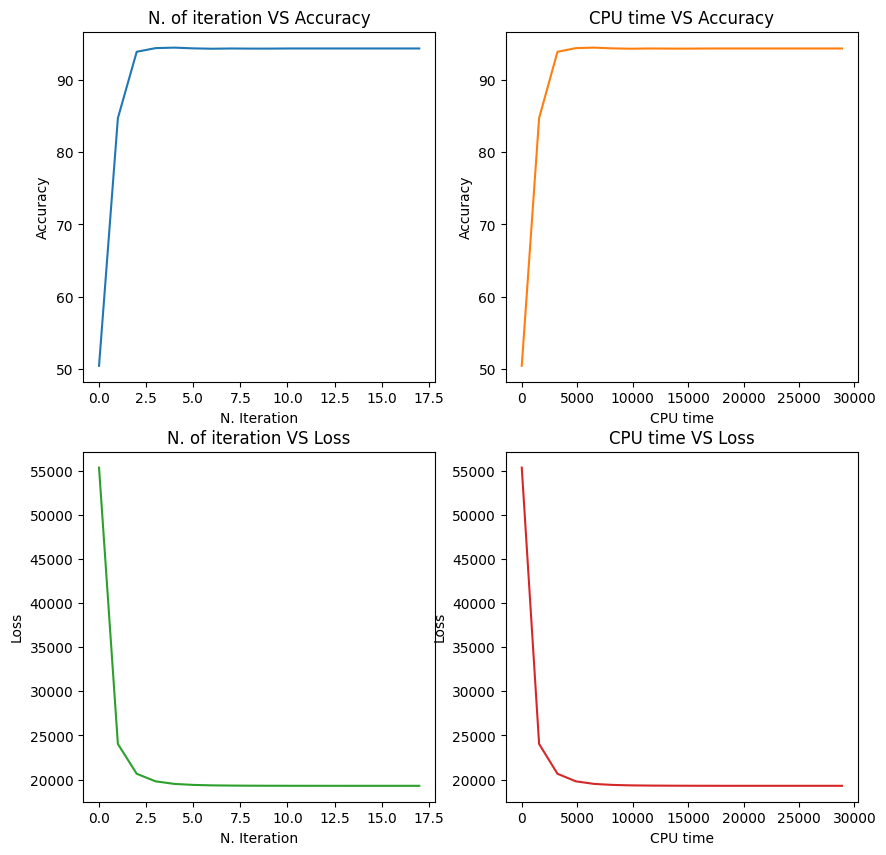

In [ ]:
%%time
### WE PLOT THE RESULTS ###
fig, axs = plt.subplots(2, 2,figsize=(10,10))
axs[0, 0].plot(vec_iter_ELS, vec_accuracy_ELS, 'tab:blue')
axs[0, 0].set_title('N. of iteration VS Accuracy')
axs[0, 0].set_xlabel('N. Iteration')
axs[0, 0].set_ylabel("Accuracy")

axs[0, 1].plot(ticks_ELS, vec_accuracy_ELS, 'tab:orange')
axs[0, 1].set_title('CPU time VS Accuracy')
axs[0, 1].set_xlabel('CPU time')
axs[0, 1].set_ylabel("Accuracy")

axs[1, 0].plot(vec_iter_ELS, vec_loss_ELS, 'tab:green')
axs[1, 0].set_title('N. of iteration VS Loss')
axs[1, 0].set_xlabel('N. Iteration')
axs[1, 0].set_ylabel('Loss')

axs[1, 1].plot(ticks_ELS, vec_loss_ELS, 'tab:red')
axs[1, 1].set_title('CPU time VS Loss')
axs[1, 1].set_xlabel('CPU time')
axs[1, 1].set_ylabel('Loss')

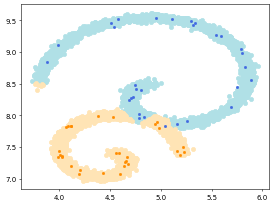

In [ ]:
y_GS_ELS = [1 if i >= 0 else -1 for i in y_GS_ELS]

x1_GD_ELS = x_unlabeled[y_GS_ELS==np.ones(n_unlabeled)]
y1_GD_ELS = y_unlabeled[y_GS_ELS==np.ones(n_unlabeled)]
x2_GD_ELS = x_unlabeled[y_GS_ELS==-np.ones(n_unlabeled)]
y2_GD_ELS = y_unlabeled[y_GS_ELS==-np.ones(n_unlabeled)]
plt.figure(dpi=50)
plt.scatter(x1_GD_ELS,y1_GD_ELS,c='powderblue')
plt.scatter(x2_GD_ELS,y2_GD_ELS,c='moccasin')
plt.scatter(x1_l, y1_l, s=10, c='royalblue')
plt.scatter(x2_l, y2_l, s=10, c='darkorange')

## BCGD

In [ ]:
column_sum = np.sum(w_uu, axis = 0) + np.sum(w_lu, axis = 0)
def step_gradient(grad, alpha, i):
    grad_1 = grad.copy()
    grad_1 += 2 * w_uu[i] * alpha
    grad_1[i] -= 2 * alpha * column_sum[i]
    return grad_1

In [ ]:
def element_loss(x,i):
    term_1 = np.dot(w_lu[:,i], (x - labels)**2)
    term_2 = np.dot(w_uu[:,i], (x - unlabels)**2)
    return term_1 + 0.5 * term_2

### Gauss-Southwell BCGD (L)

In [ ]:
def GS_BCGD_L(y_0):
  start = time.time()
  y = y_0.copy()
  tol = 1e-2

  init_time = time.time() * 1000

  numiter = 0
  maxiter = 25000
  
  grad = vector_gradient(y)
  normgrad = np.linalg.norm(grad, 2)
  loss = vector_loss(y)

  vec_iter_GS_BCGD = [0]
  vec_accuracy_GS_BCGD = [accuracy(y)]
  vec_loss_GS_BCGD = [loss]
  ticks_GS_BCGD = [time.time() * 1000 - init_time]

  print("Initial loss = {} -- Initial accuracy = {}".format(vec_loss_gd[0], vec_accuracy_gd[0]))

  while normgrad > tol and numiter < maxiter:

    numiter += 1

    argmax = np.argmax(np.abs(grad))
    loss -= element_loss(y[argmax], argmax)
    alpha = (1/L) * grad[argmax]
    y[argmax] -= alpha
    grad = step_gradient(grad, alpha, argmax)
    loss += element_loss(y[argmax], argmax)
    acc = accuracy(y)
    normgrad = np.linalg.norm(grad, 2)

    vec_iter_GS_BCGD.append(numiter)
    vec_accuracy_GS_BCGD.append(acc)
    vec_loss_GS_BCGD.append(loss)

    print("Iteration {} -- Loss: {} -- Accuracy: {}".format(numiter, loss, acc))
    ticks_GS_BCGD.append(time.time() * 1000 - init_time)

  end = time.time()
  print("Time = {}".format((end-start)))
  print(y)
  return y, vec_iter_GS_BCGD, vec_accuracy_GS_BCGD, vec_loss_GS_BCGD, ticks_GS_BCGD
  

In [ ]:
y_GS_BCGD_L, vec_iter_GS_BCGD_L, vec_accuracy_GS_BCGD_L, vec_loss_GS_BCGD_L, ticks_GS_BCGD_L = GS_BCGD_L(y_0)

Output streaming troncato alle ultime 5000 righe.
Iterazione 20004 -- Loss: 13382.773938729188 -- Accuracy: 94.07407407407405
Iterazione 20005 -- Loss: 13382.546102536826 -- Accuracy: 94.07407407407405
Iterazione 20006 -- Loss: 13382.302073731755 -- Accuracy: 94.07407407407405
Iterazione 20007 -- Loss: 13382.146501905736 -- Accuracy: 94.07407407407405
Iterazione 20008 -- Loss: 13381.890653155697 -- Accuracy: 94.07407407407405
Iterazione 20009 -- Loss: 13381.655177552817 -- Accuracy: 94.07407407407405
Iterazione 20010 -- Loss: 13381.5083968292 -- Accuracy: 94.07407407407405
Iterazione 20011 -- Loss: 13381.324571340365 -- Accuracy: 94.07407407407405
Iterazione 20012 -- Loss: 13381.036420680637 -- Accuracy: 94.07407407407405
Iterazione 20013 -- Loss: 13380.798039771444 -- Accuracy: 94.07407407407405
Iterazione 20014 -- Loss: 13380.533567195393 -- Accuracy: 94.07407407407405
Iterazione 20015 -- Loss: 13380.366760017294 -- Accuracy: 94.07407407407405
Iterazione 20016 -- Loss: 13380.43498792

Text(0, 0.5, 'Loss')

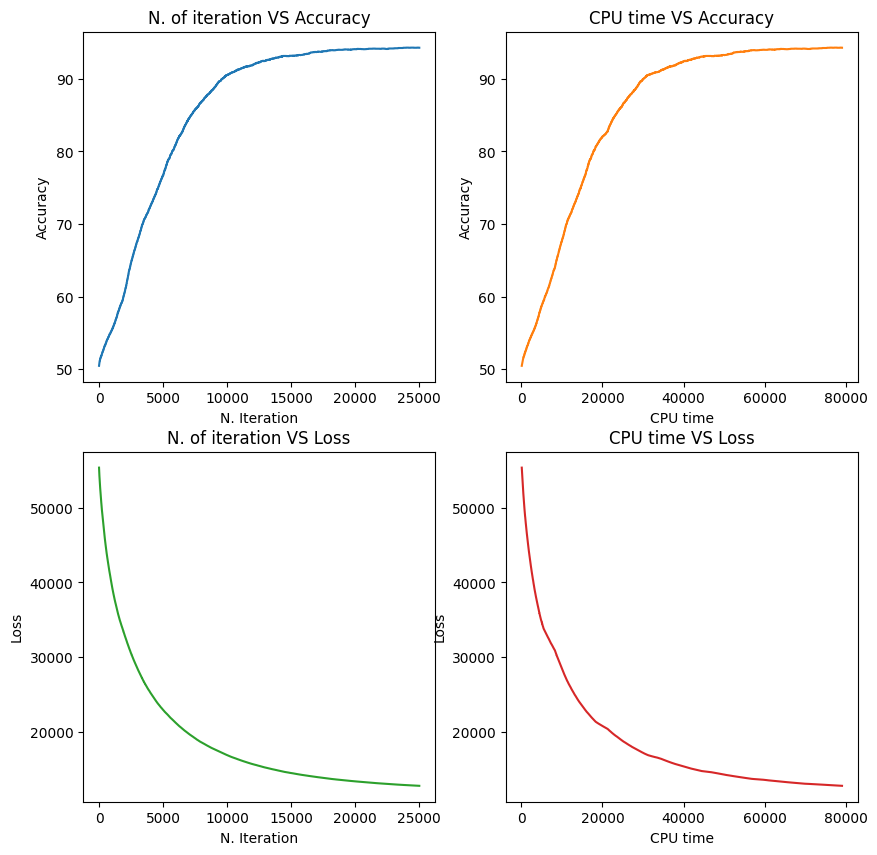

In [ ]:
### WE PLOT THE RESULTS ###
fig, axs = plt.subplots(2, 2,figsize=(10,10))
axs[0, 0].plot(vec_iter_GS_BCGD_L, vec_accuracy_GS_BCGD_L,'tab:blue')
axs[0, 0].set_title('N. of iteration VS Accuracy')
axs[0, 0].set_xlabel('N. Iteration')
axs[0, 0].set_ylabel("Accuracy")

axs[0, 1].plot(ticks_GS_BCGD_L, vec_accuracy_GS_BCGD_L, 'tab:orange')
axs[0, 1].set_title('CPU time VS Accuracy')
axs[0, 1].set_xlabel('CPU time')
axs[0, 1].set_ylabel("Accuracy")

axs[1, 0].plot(vec_iter_GS_BCGD_L, vec_loss_GS_BCGD_L, 'tab:green')
axs[1, 0].set_title('N. of iteration VS Loss')
axs[1, 0].set_xlabel('N. Iteration')
axs[1, 0].set_ylabel('Loss')

axs[1, 1].plot(ticks_GS_BCGD_L, vec_loss_GS_BCGD_L, 'tab:red')
axs[1, 1].set_title('CPU time VS Loss')
axs[1, 1].set_xlabel('CPU time')
axs[1, 1].set_ylabel('Loss')

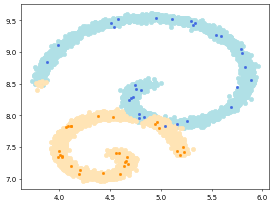

In [ ]:
y_GS_BCGD_L = [1 if i >= 0 else -1 for i in y_GS_BCGD_L]

x1_GS_BCGD_L = x_unlabeled[y_GS_BCGD_L==np.ones(n_unlabeled)]
y1_GS_BCGD_L = y_unlabeled[y_GS_BCGD_L==np.ones(n_unlabeled)]
x2_GS_BCGD_L = x_unlabeled[y_GS_BCGD_L==-np.ones(n_unlabeled)]
y2_GS_BCGD_L = y_unlabeled[y_GS_BCGD_L==-np.ones(n_unlabeled)]
plt.figure(dpi=50)
plt.scatter(x1_GS_BCGD_L, y1_GS_BCGD_L, c='powderblue')
plt.scatter(x2_GS_BCGD_L, y2_GS_BCGD_L, c='moccasin')
plt.scatter(x1_l, y1_l, s=10, c='royalblue')
plt.scatter(x2_l, y2_l, s=10, c='darkorange')

### Gauss-Southwell BCGD (L_i)

In [ ]:
def GS_BCGD_Li(y_0):
  start = time.time()
  y = y_0.copy()
  tol = 1e-2

  init_time = time.time() * 1000

  numiter = 0
  maxiter = 25000

  grad = vector_gradient(y)
  normgrad = np.linalg.norm(grad, 2)
  norm_incr = 1
  loss = vector_loss(y)
 
  vec_iter_GS_BCGD = [0]
  vec_accuracy_GS_BCGD = [accuracy(y)]
  vec_loss_GS_BCGD = [loss]
  ticks_GS_BCGD = [time.time() * 1000 - init_time]

  print("Initial loss = {} -- Initial accuracy = {}".format(vec_loss_gd[0], vec_accuracy_gd[0]))

  while normgrad > tol and numiter < maxiter:

    numiter += 1

    argmax = np.argmax(np.abs(grad))
    loss -= element_loss(y[argmax], argmax)
    alpha = (1/Li[argmax]) * grad[argmax]
    y[argmax] -= alpha
    grad = step_gradient(grad, alpha, argmax)
    loss += element_loss(y[argmax], argmax)
    acc = accuracy(y)
    normgrad = np.linalg.norm(grad, 2)

    vec_iter_GS_BCGD.append(numiter)
    vec_accuracy_GS_BCGD.append(acc)
    vec_loss_GS_BCGD.append(loss)

    print("Iteration {} -- Loss: {} -- Accuracy: {}".format(numiter, loss, acc))
    ticks_GS_BCGD.append(time.time() * 1000 - init_time)

  end = time.time()
  print("Time = {}".format((end-start)))
  print(y)
  return y, vec_iter_GS_BCGD, vec_accuracy_GS_BCGD, vec_loss_GS_BCGD, ticks_GS_BCGD

In [ ]:
%%time
### CALL BCGD WITH GAUSS SOUTHWELL (L_i) ###
y_GS_BCGD_Li, vec_iter_GS_BCGD_Li, vec_accuracy_GS_BCGD_Li, vec_loss_GS_BCGD_Li, ticks_GS_BCGD_Li = GS_BCGD_Li(y_0)

Output streaming troncato alle ultime 5000 righe.
Iteration 20006 -- Loss: 11952.104423589339 -- Accuracy: 94.27609427609426
Iteration 20007 -- Loss: 11952.081361506383 -- Accuracy: 94.27609427609426
Iteration 20008 -- Loss: 11952.062642809871 -- Accuracy: 94.27609427609426
Iteration 20009 -- Loss: 11952.0514298152 -- Accuracy: 94.27609427609426
Iteration 20010 -- Loss: 11952.026555399027 -- Accuracy: 94.27609427609426
Iteration 20011 -- Loss: 11952.008357377086 -- Accuracy: 94.27609427609426
Iteration 20012 -- Loss: 11951.986887820378 -- Accuracy: 94.27609427609426
Iteration 20013 -- Loss: 11951.96403641803 -- Accuracy: 94.27609427609426
Iteration 20014 -- Loss: 11951.942219960541 -- Accuracy: 94.27609427609426
Iteration 20015 -- Loss: 11951.926313637947 -- Accuracy: 94.27609427609426
Iteration 20016 -- Loss: 11951.90853329115 -- Accuracy: 94.27609427609426
Iteration 20017 -- Loss: 11951.889607274445 -- Accuracy: 94.27609427609426
Iteration 20018 -- Loss: 11951.869978619878 -- Accurac

CPU times: user 96.5 ms, sys: 4.64 ms, total: 101 ms
Wall time: 98.9 ms


Text(0, 0.5, 'Loss')

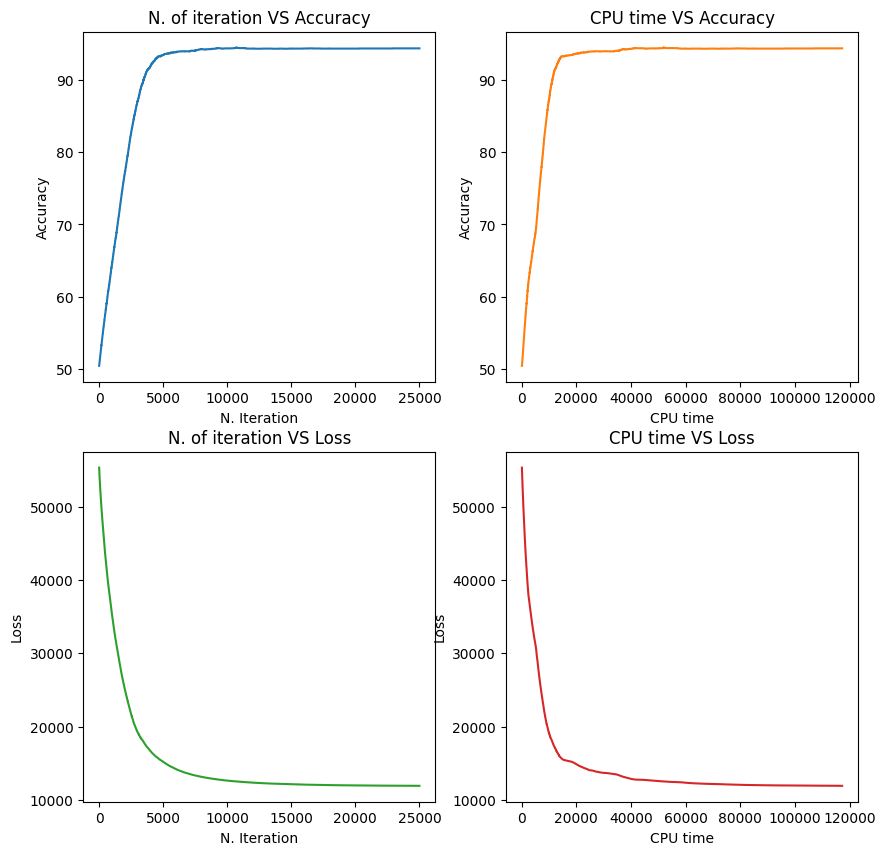

In [ ]:
%%time
### WE PLOT THE RESULTS ###
fig, axs = plt.subplots(2, 2,figsize=(10,10))
axs[0, 0].plot(vec_iter_GS_BCGD_Li, vec_accuracy_GS_BCGD_Li,'tab:blue')
axs[0, 0].set_title('N. of iteration VS Accuracy')
axs[0, 0].set_xlabel('N. Iteration')
axs[0, 0].set_ylabel("Accuracy")

axs[0, 1].plot(ticks_GS_BCGD_Li, vec_accuracy_GS_BCGD_Li, 'tab:orange')
axs[0, 1].set_title('CPU time VS Accuracy')
axs[0, 1].set_xlabel('CPU time')
axs[0, 1].set_ylabel("Accuracy")

axs[1, 0].plot(vec_iter_GS_BCGD_Li, vec_loss_GS_BCGD_Li, 'tab:green')
axs[1, 0].set_title('N. of iteration VS Loss')
axs[1, 0].set_xlabel('N. Iteration')
axs[1, 0].set_ylabel('Loss')

axs[1, 1].plot(ticks_GS_BCGD_Li , vec_loss_GS_BCGD_Li, 'tab:red')
axs[1, 1].set_title('CPU time VS Loss')
axs[1, 1].set_xlabel('CPU time')
axs[1, 1].set_ylabel('Loss')

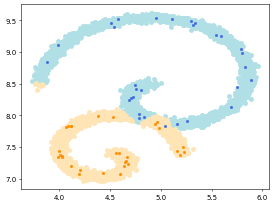

In [ ]:
y_GS_BCGD_Li = [1 if i >= 0 else -1 for i in y_GS_BCGD_Li]

x1_GS_BCGD_Li = x_unlabeled[y_GS_BCGD_Li == np.ones(n_unlabeled)]
y1_GS_BCGD_Li = y_unlabeled[y_GS_BCGD_Li == np.ones(n_unlabeled)]
x2_GS_BCGD_Li = x_unlabeled[y_GS_BCGD_Li == -np.ones(n_unlabeled)]
y2_GS_BCGD_Li = y_unlabeled[y_GS_BCGD_Li == -np.ones(n_unlabeled)]
plt.figure(dpi=50)
plt.scatter(x1_GS_BCGD_Li, y1_GS_BCGD_Li, c='powderblue')
plt.scatter(x2_GS_BCGD_Li, y2_GS_BCGD_Li, c='moccasin')
plt.scatter(x1_l, y1_l, s=10, c='royalblue')
plt.scatter(x2_l, y2_l, s=10, c='darkorange')

### Random BCGD_Li (Nesterov)

In [ ]:

def random_BCGDLi_Nesterov(y_0):
  y = y_0.copy()
  start = time.time()
  numiter = 0
  maxiter = 25000
  tol = 1e-2

  init_time = time.time() * 1000
 
  grad = vector_gradient(y)
  normgrad = np.linalg.norm(grad, 2)
  loss = vector_loss(y)
  
  vec_iter_nesterov = [0]
  vec_accuracy_nesterov = [accuracy(y)]
  vec_loss_nesterov = [loss]
  ticks_nesterov = [time.time() * 1000 - init_time]

  print("Initial loss = {} -- Initial accuracy = {}".format(vec_loss_gd[0], vec_accuracy_gd[0]))


  while numiter < maxiter and normgrad > tol:
    
    numiter += 1

    i = np.random.choice(n_unlabeled, p = probs)
    old_loss = element_loss(y[i], i)
    alpha = 1/Li[i] * grad[i]
    y[i] -= alpha
    grad = step_gradient(grad, alpha, i)
    new_loss = element_loss(y[i], i)
    loss = loss - old_loss + new_loss
    acc = accuracy(y)
    normgrad = np.linalg.norm(grad, 2)
   
    vec_iter_nesterov.append(numiter)
    vec_accuracy_nesterov.append(acc)
    vec_loss_nesterov.append(loss)

    print("Iteration {} -- Loss: {} -- Accuracy: {}".format(numiter, loss, acc))

    ticks_nesterov.append(time.time() * 1000 - init_time)

  end = time.time()
  print("Time = {}".format((end-start)))
  print(y)
  return y, vec_iter_nesterov, vec_accuracy_nesterov, vec_loss_nesterov, ticks_nesterov

In [ ]:
%%time
### WE CALL THE FUNCTION RANDOM BCGD WITH L_i (Nesterov) ###
y_nesterov, vec_iter_nesterov, vec_accuracy_nesterov, vec_loss_nesterov, ticks_nesterov  = random_BCGDLi_Nesterov(y_0)


Output streaming troncato alle ultime 5000 righe.
Iterazione 20006 -- Loss: 16251.861677352896 -- Accuracy: 91.88552188552187
Iterazione 20007 -- Loss: 16251.861856878078 -- Accuracy: 91.88552188552187
Iterazione 20008 -- Loss: 16251.848134378783 -- Accuracy: 91.88552188552187
Iterazione 20009 -- Loss: 16251.66702542642 -- Accuracy: 91.88552188552187
Iterazione 20010 -- Loss: 16251.643638869546 -- Accuracy: 91.88552188552187
Iterazione 20011 -- Loss: 16251.623366960504 -- Accuracy: 91.88552188552187
Iterazione 20012 -- Loss: 16251.5978720148 -- Accuracy: 91.88552188552187
Iterazione 20013 -- Loss: 16251.596746843612 -- Accuracy: 91.88552188552187
Iterazione 20014 -- Loss: 16251.332349172977 -- Accuracy: 91.88552188552187
Iterazione 20015 -- Loss: 16251.226427996866 -- Accuracy: 91.88552188552187
Iterazione 20016 -- Loss: 16251.090551618548 -- Accuracy: 91.88552188552187
Iterazione 20017 -- Loss: 16251.088893188242 -- Accuracy: 91.88552188552187
Iterazione 20018 -- Loss: 16251.087859644

CPU times: user 96.9 ms, sys: 5.32 ms, total: 102 ms
Wall time: 99.9 ms


Text(0, 0.5, 'Loss')

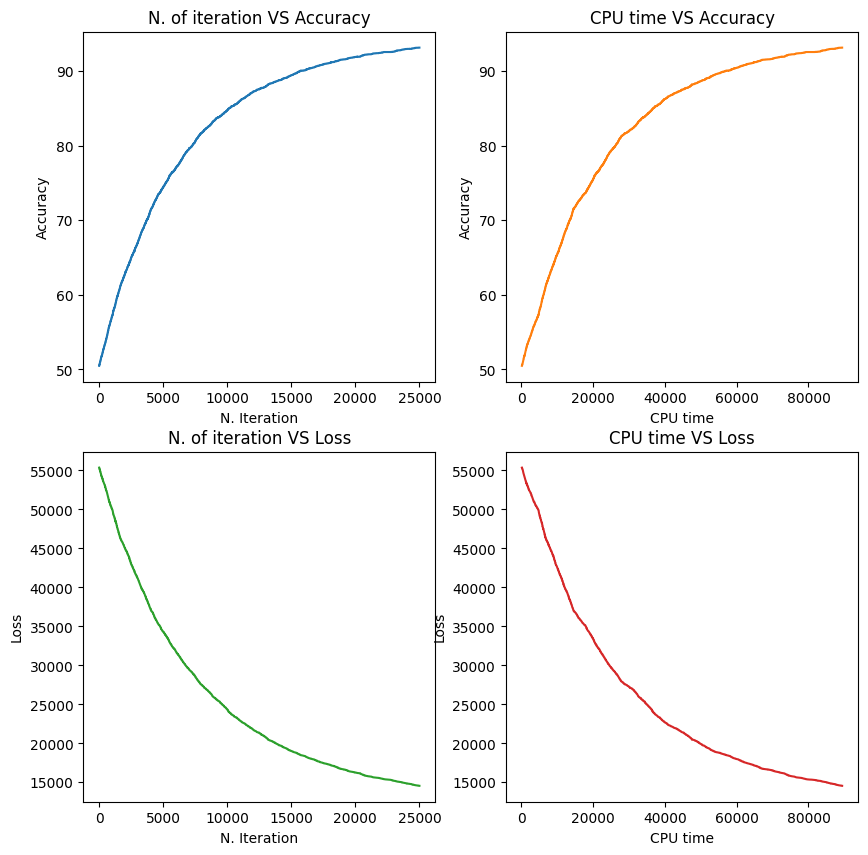

In [ ]:
%%time
### WE PLOT THE RESULTS ###
fig, axs = plt.subplots(2, 2,figsize=(10,10))
axs[0, 0].plot(vec_iter_nesterov ,vec_accuracy_nesterov ,'tab:blue')
axs[0, 0].set_title('N. of iteration VS Accuracy')
axs[0, 0].set_xlabel('N. Iteration')
axs[0, 0].set_ylabel("Accuracy")

axs[0, 1].plot(ticks_nesterov, vec_accuracy_nesterov , 'tab:orange')
axs[0, 1].set_title('CPU time VS Accuracy')
axs[0, 1].set_xlabel('CPU time')
axs[0, 1].set_ylabel("Accuracy")

axs[1, 0].plot(vec_iter_nesterov , vec_loss_nesterov, 'tab:green')
axs[1, 0].set_title('N. of iteration VS Loss')
axs[1, 0].set_xlabel('N. Iteration')
axs[1, 0].set_ylabel('Loss')

axs[1, 1].plot(ticks_nesterov , vec_loss_nesterov , 'tab:red')
axs[1, 1].set_title('CPU time VS Loss')
axs[1, 1].set_xlabel('CPU time')
axs[1, 1].set_ylabel('Loss')

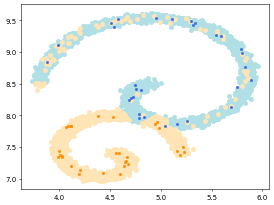

In [ ]:
y_nesterov=[1 if i >= 0 else -1 for i in y_nesterov]

x1_nesterov=x_unlabeled[y_nesterov==np.ones(n_unlabeled)]
y1_nesterov=y_unlabeled[y_nesterov==np.ones(n_unlabeled)]
x2_nesterov=x_unlabeled[y_nesterov==-np.ones(n_unlabeled)]
y2_nesterov=y_unlabeled[y_nesterov==-np.ones(n_unlabeled)]
plt.figure(dpi=50)
plt.scatter(x1_nesterov,y1_nesterov,c='powderblue')
plt.scatter(x2_nesterov,y2_nesterov,c='moccasin')
plt.scatter(x1_l, y1_l, s=10, c='royalblue')
plt.scatter(x2_l, y2_l, s=10, c='darkorange')

### Random BCGD_Li (Uniform)

In [ ]:
def random_BCGDLi(y_0):
  y = y_0.copy()
  start = time.time()
  numiter = 0
  maxiter = 25000
  tol = 1e-2

  init_time = time.time() * 1000

  grad = vector_gradient(y)
  normgrad = np.linalg.norm(grad, 2)
  loss = vector_loss(y)
  norm_incr = 1

  vec_iter_Li_Uniform = [0]
  vec_accuracy_Li_Uniform = [accuracy(y)]
  vec_loss_Li_Uniform = [loss]
  ticks_Li_Uniform = [time.time() * 1000 - init_time]

  print("Initial loss = {} -- Initial accuracy = {}".format(vec_loss_gd[0], vec_accuracy_gd[0]))


  while numiter < maxiter and normgrad > tol:

    numiter += 1

    i = np.random.randint(0, n_unlabeled-1)
    loss -= element_loss(y[i], i)
    alpha = (1/Li[i]) * grad[i]
    y[i] -= alpha
    grad = step_gradient(grad, alpha, i)
    loss += element_loss(y[i], i)
    acc = accuracy(y)
    normgrad = np.linalg.norm(grad, 2)

    vec_iter_Li_Uniform.append(numiter)
    vec_accuracy_Li_Uniform.append(acc)
    vec_loss_Li_Uniform.append(loss)
    
    print("Iteration {} -- Loss: {} -- Accuracy: {}".format(numiter, loss, acc))

    ticks_Li_Uniform.append(time.time() * 1000 - init_time)

  end = time.time()
  print("Time = {}".format((end-start)))
  print(y)
  return y,vec_iter_Li_Uniform,vec_accuracy_Li_Uniform,vec_loss_Li_Uniform,ticks_Li_Uniform

In [ ]:
%%time
### WE CALL THE FUNCTION RANDOM BCGD_Li (Uniform) ###
y_Li_Uniform, vec_iter_Li_Uniform, vec_accuracy_Li_Uniform, vec_loss_Li_Uniform, ticks_Li_Uniform = random_BCGDLi(y_0)


Output streaming troncato alle ultime 5000 righe.
Iterazione 20006 -- Loss: 15768.4668468641 -- Accuracy: 92.69360269360267
Iterazione 20007 -- Loss: 15768.215420581779 -- Accuracy: 92.69360269360267
Iterazione 20008 -- Loss: 15768.07284406606 -- Accuracy: 92.69360269360267
Iterazione 20009 -- Loss: 15767.477319398127 -- Accuracy: 92.69360269360267
Iterazione 20010 -- Loss: 15767.328030931 -- Accuracy: 92.69360269360267
Iterazione 20011 -- Loss: 15767.250781219835 -- Accuracy: 92.69360269360267
Iterazione 20012 -- Loss: 15767.14393718241 -- Accuracy: 92.69360269360267
Iterazione 20013 -- Loss: 15767.140730945015 -- Accuracy: 92.69360269360267
Iterazione 20014 -- Loss: 15766.531865309827 -- Accuracy: 92.69360269360267
Iterazione 20015 -- Loss: 15766.530872686018 -- Accuracy: 92.69360269360267
Iterazione 20016 -- Loss: 15766.528314069168 -- Accuracy: 92.69360269360267
Iterazione 20017 -- Loss: 15766.376802799283 -- Accuracy: 92.69360269360267
Iterazione 20018 -- Loss: 15766.260362167937 

CPU times: user 97.8 ms, sys: 4.14 ms, total: 102 ms
Wall time: 103 ms


Text(0, 0.5, 'Loss')

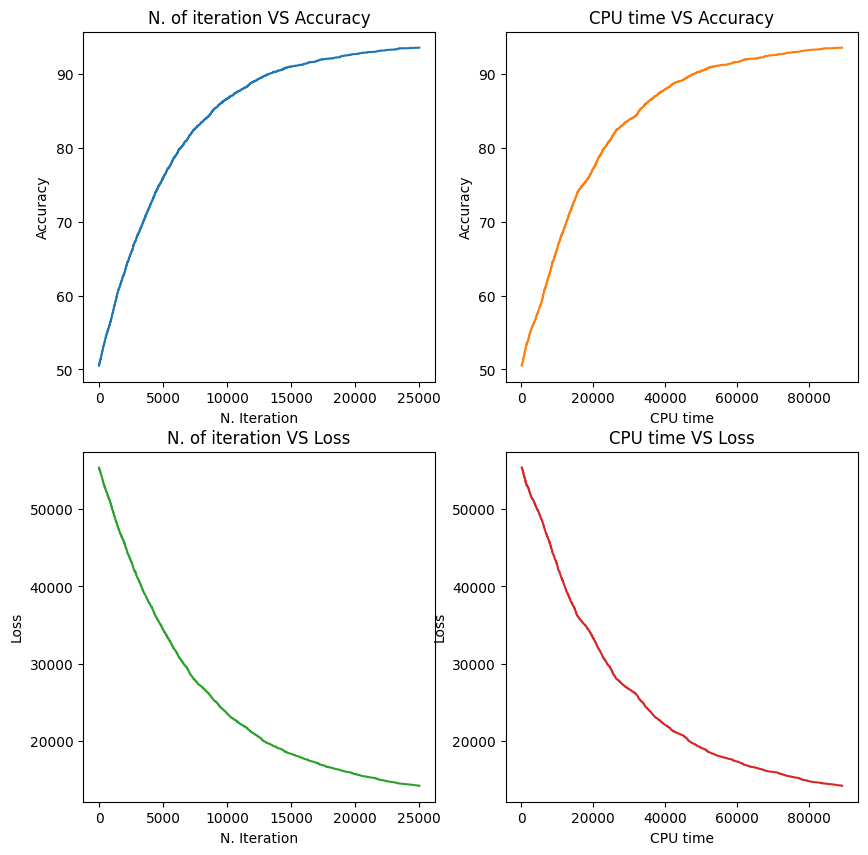

In [ ]:
%%time
### WE PLOT THE RESULTS ###
fig, axs = plt.subplots(2, 2,figsize=(10,10))
axs[0, 0].plot(vec_iter_Li_Uniform ,vec_accuracy_Li_Uniform ,'tab:blue')
axs[0, 0].set_title('N. of iteration VS Accuracy')
axs[0, 0].set_xlabel('N. Iteration')
axs[0, 0].set_ylabel("Accuracy")

axs[0, 1].plot(ticks_Li_Uniform , vec_accuracy_Li_Uniform, 'tab:orange')
axs[0, 1].set_title('CPU time VS Accuracy')
axs[0, 1].set_xlabel('CPU time')
axs[0, 1].set_ylabel("Accuracy")

axs[1, 0].plot(vec_iter_Li_Uniform, vec_loss_Li_Uniform , 'tab:green')
axs[1, 0].set_title('N. of iteration VS Loss')
axs[1, 0].set_xlabel('N. Iteration')
axs[1, 0].set_ylabel('Loss')

axs[1, 1].plot(ticks_Li_Uniform, vec_loss_Li_Uniform , 'tab:red')
axs[1, 1].set_title('CPU time VS Loss')
axs[1, 1].set_xlabel('CPU time')
axs[1, 1].set_ylabel('Loss')

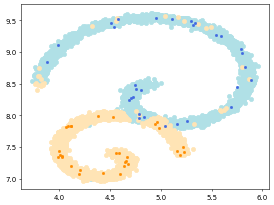

In [ ]:
y_Li_Uniform=[1 if i >= 0 else -1 for i in y_Li_Uniform]

x1_Li_Uniform=x_unlabeled[y_Li_Uniform==np.ones(n_unlabeled)]
y1_Li_Uniform=y_unlabeled[y_Li_Uniform==np.ones(n_unlabeled)]
x2_Li_Uniform=x_unlabeled[y_Li_Uniform==-np.ones(n_unlabeled)]
y2_Li_Uniform=y_unlabeled[y_Li_Uniform==-np.ones(n_unlabeled)]
plt.figure(dpi=50)
plt.scatter(x1_Li_Uniform,y1_Li_Uniform,c='powderblue')
plt.scatter(x2_Li_Uniform,y2_Li_Uniform,c='moccasin')
plt.scatter(x1_l, y1_l, s=10, c='royalblue')
plt.scatter(x2_l, y2_l, s=10, c='darkorange')

## Plot comparison

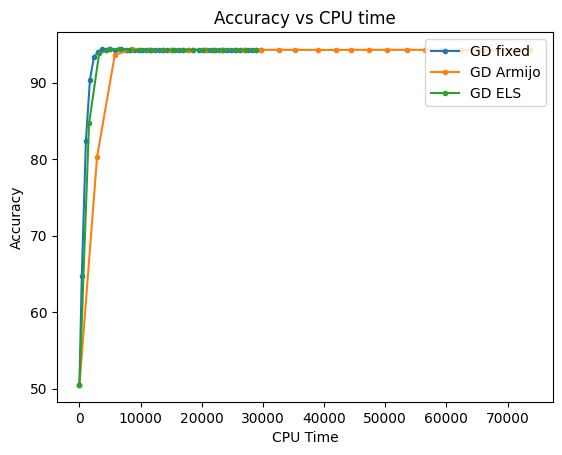

In [ ]:
### PLOT CONFRONTATION ON ACCURACY VS CPU TIME ###
plt.figure(dpi=100)
plt.plot(ticks_gd,vec_accuracy_gd,marker='.')
plt.plot(ticks_gsArmijo,vec_accuracy_gsArmijo,marker='.')
plt.plot(ticks_ELS,vec_accuracy_ELS,marker='.')
plt.title("Accuracy vs CPU time")
plt.xlabel("CPU Time")
plt.ylabel("Accuracy")
plt.legend(
    ['GD fixed',
    'GD Armijo',
    'GD ELS'
    ],
    loc="upper right"
)

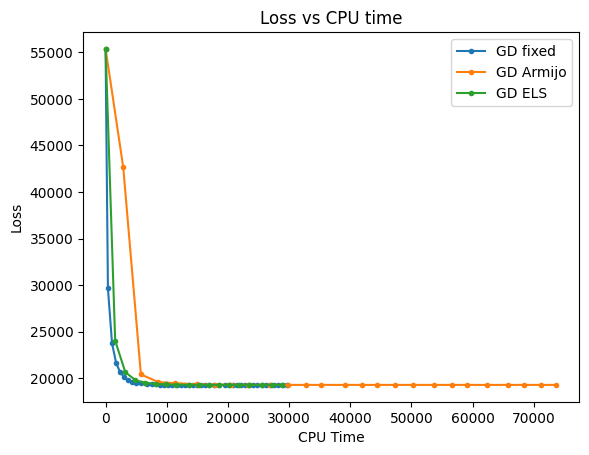

In [ ]:
### PLOT CONFRONTATION ON LOSS VS CPU TIME ###
plt.figure(dpi=100)
plt.plot(ticks_gd, vec_loss_gd, marker='.')
plt.plot(ticks_gsArmijo, vec_loss_gsArmijo, marker='.')
plt.plot(ticks_ELS, vec_loss_ELS, marker='.')

plt.title("Loss vs CPU time")
plt.xlabel("CPU Time")
plt.ylabel("Loss")
plt.legend(
    ['GD fixed',
    'GD Armijo',
    'GD ELS'],
    loc="upper right"
)

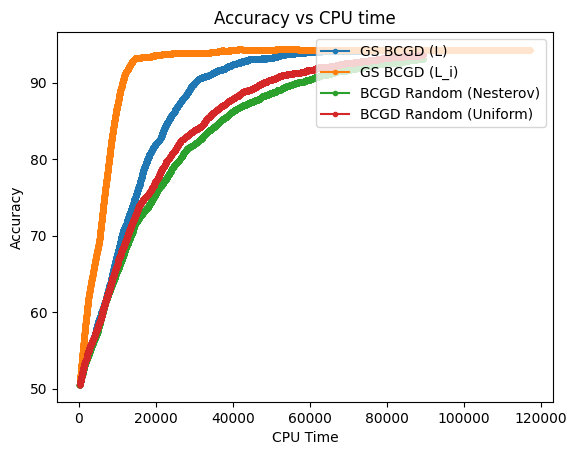

In [ ]:
### PLOT CONFRONTATION ON ACCURACY VS CPU TIME ###
plt.figure(dpi=100)

plt.plot(ticks_GS_BCGD_L, vec_accuracy_GS_BCGD_L, marker = '.')
plt.plot(ticks_GS_BCGD_Li, vec_accuracy_GS_BCGD_Li, marker = '.')
plt.plot(ticks_nesterov, vec_accuracy_nesterov, marker = '.')
plt.plot(ticks_Li_Uniform,vec_accuracy_Li_Uniform,marker = '.')
plt.title("Accuracy vs CPU time")
plt.xlabel("CPU Time")
plt.ylabel("Accuracy")
plt.legend(
    [ 
    'GS BCGD (L)',
    'GS BCGD (L_i)',
    'BCGD Random (Nesterov)',
    'BCGD Random (Uniform)'],
    loc="upper right"
)


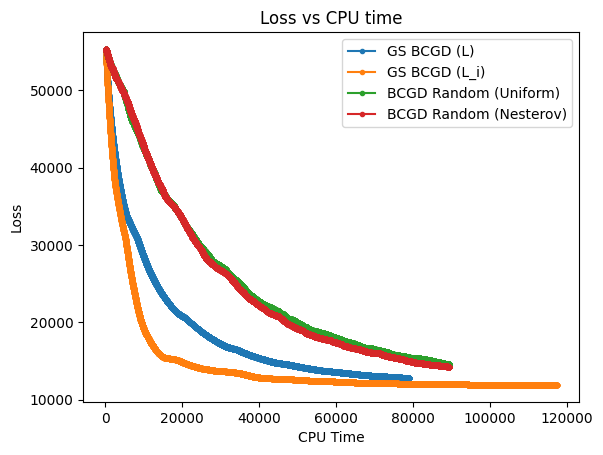

In [ ]:
### PLOT CONFRONTATION ON LOSS VS CPU TIME ###
plt.figure(dpi=100)
plt.plot(ticks_GS_BCGD_L, vec_loss_GS_BCGD_L, marker = '.')
plt.plot(ticks_GS_BCGD_Li, vec_loss_GS_BCGD_Li, marker = '.')
plt.plot(ticks_nesterov, vec_loss_nesterov, marker='.')
plt.plot(ticks_Li_Uniform, vec_loss_Li_Uniform, marker='.')
plt.title("Loss vs CPU time")
plt.xlabel("CPU Time")
plt.ylabel("Loss")
plt.legend(
    ['GS BCGD (L)',
    'GS BCGD (L_i)',
    'BCGD Random (Uniform)',
    'BCGD Random (Nesterov)'],
    loc="upper right"
)

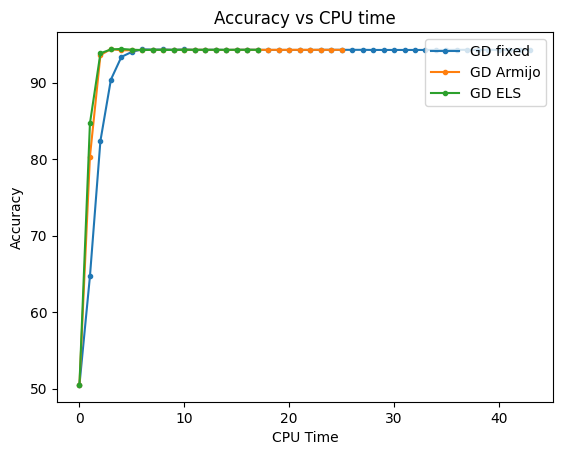

In [ ]:
### PLOT CONFRONTATION ON ACCURACY VS ITERATIONS ###
plt.figure(dpi=100)
plt.plot(vec_iter_gd, vec_accuracy_gd, marker='.')
plt.plot(vec_iter_gsArmijo,vec_accuracy_gsArmijo,marker='.')
plt.plot(vec_iter_ELS, vec_accuracy_ELS,marker='.')
plt.title("Accuracy vs N. of iterations")
plt.xlabel("N. of iterations")
plt.ylabel("Accuracy")
plt.legend(
    ['GD fixed',
    'GD Armijo',
    'GD ELS'
    ],
    loc="upper right"
)

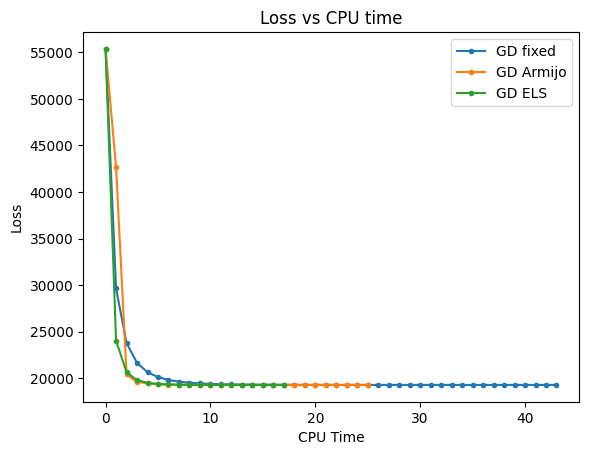

In [ ]:
### PLOT CONFRONTATION ON LOSS VS ITERATIONS ###
plt.figure(dpi=100)
plt.plot(vec_iter_gd, vec_loss_gd, marker='.')
plt.plot(vec_iter_gsArmijo, vec_loss_gsArmijo, marker='.')
plt.plot(vec_iter_ELS, vec_loss_ELS, marker='.')

plt.title("Loss vs N. of iterations")
plt.xlabel("N. of iterations")
plt.ylabel("Loss")
plt.legend(
    ['GD fixed',
    'GD Armijo',
    'GD ELS'],
    loc="upper right"
)

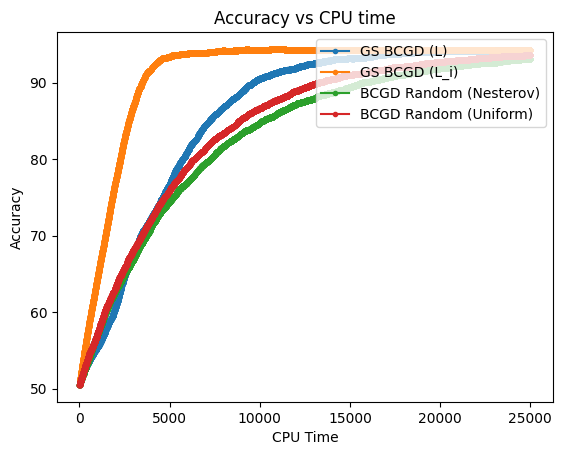

In [ ]:
### PLOT CONFRONTATION ON ACCURACY VS N OF ITERATIONS ###
plt.figure(dpi=100)

plt.plot(vec_iter_GS_BCGD_L, vec_accuracy_GS_BCGD_L, marker = '.')
plt.plot(vec_iter_GS_BCGD_Li, vec_accuracy_GS_BCGD_Li, marker = '.')
plt.plot(vec_iter_nesterov, vec_accuracy_nesterov, marker = '.')
plt.plot(vec_iter_Li_Uniform,vec_accuracy_Li_Uniform,marker = '.')
plt.title("Accuracy vs N. of iterations")
plt.xlabel("N. of iterations")
plt.ylabel("Accuracy")
plt.legend(
    [ 
    'GS BCGD (L)',
    'GS BCGD (L_i)',
    'BCGD Random (Nesterov)',
    'BCGD Random (Uniform)'],
    loc="upper right"
)


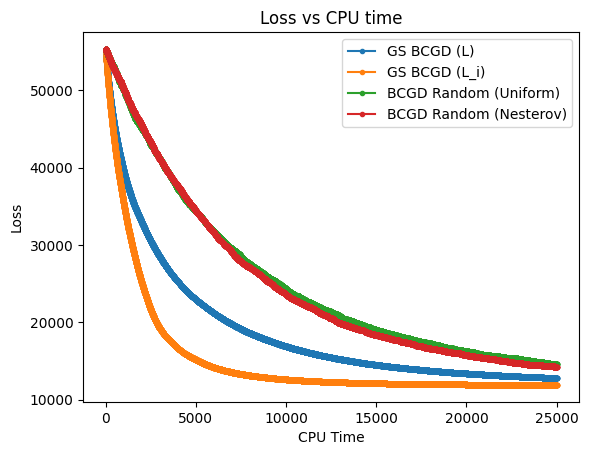

In [ ]:
### PLOT CONFRONTATION ON LOSS VS CPU TIME ###
plt.figure(dpi=100)
plt.plot(vec_iter_GS_BCGD_L, vec_loss_GS_BCGD_L, marker = '.')
plt.plot(vec_iter_GS_BCGD_Li, vec_loss_GS_BCGD_Li, marker = '.')
plt.plot(vec_iter_nesterov, vec_loss_nesterov, marker='.')
plt.plot(vec_iter_Li_Uniform, vec_loss_Li_Uniform, marker='.')
plt.title("Loss vs N. of iterations")
plt.xlabel("N. of iterations")
plt.ylabel("Loss")
plt.legend(
    ['GS BCGD (L)',
    'GS BCGD (L_i)',
    'BCGD Random (Uniform)',
    'BCGD Random (Nesterov)'],
    loc="upper right"
)